# MNIST fastion dataset image classification

## Objective

To build a model that will predict the class of an image.  The classes are:
  - 0: Sneaker
  - 1: Boot
  - 2: Shirt
  - 3: T-shirt

*Note: This task has been given to me as part of a data science boot camp.  The y_test data was not provided and is used to score the model after submission.  If this was a standalone project then I would split the data into training and testing sets but this is not necessary here as a testing stage is integral to submission.*

## Plan

I am going to use a neural network with simmilar aspects to to VGG16 network - (3, 3) filters on convilutional layers and step down output size with maxpooling.

## Imports and loading data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

Loading the data:

In [87]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
y_train = np.load('data/y_train.npy')

And having a look at some images:

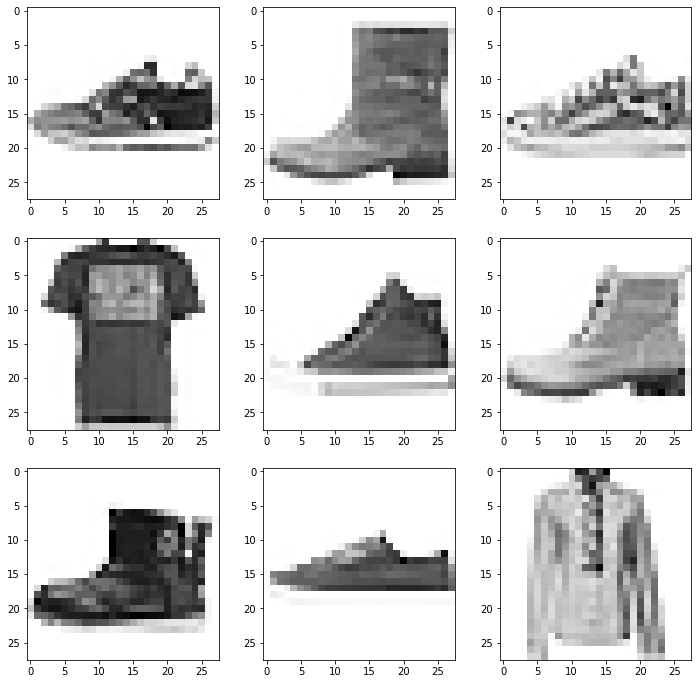

In [3]:
plt.figure(figsize=(12, 12))
images = np.random.randint(0, 20000, size=9)

for ii, plot in enumerate(np.arange(331, 340)):
    plt.subplot(plot)
    plt.imshow(X_train[images[ii]], cmap='Greys')

How balanced are the categories?

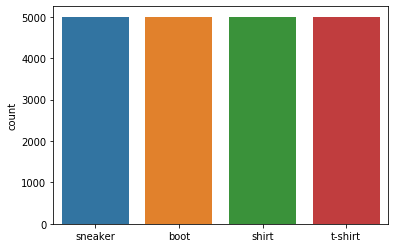

In [4]:
sns.countplot(y_train)
plt.xticks([0, 1, 2, 3], ['sneaker', 'boot', 'shirt', 't-shirt']);

Perfectly balanced!  No need for stratification.

# Modeling

Here I will use a convolutional neural network to classify the images.

In [5]:
from keras.models import Sequential

from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.models import load_model

Using TensorFlow backend.


Encode the categories and reshape the inputs to show single channel:

In [88]:
y_train = np_utils.to_categorical(y_train)
X_train = X_train.reshape(-1, 28, 28, 1)

## Model builder function

I will a function to help with the modelling stage.

I plan on grid searching some hyperparameters and architectures so I need a model builder function which will handle this.

I will start by coppying the general architecture of vgg which has the following aspects:
* Convolutional layers that are followed by stepping down input size with max pooling.
* Doubling the number of filters in the convolutional layers arfter each pooling layer.
* Finishing with dense layers.
* (3, 3) filters.
* softmax activation on the final predictions layer.
* Dropout before the dense layers to avoid overfitting.

I need to be able to alter:
* The amount of pooling steps.
* The amount of convolutional layers between pooling steps.
* The amount of dense layers.
* The following hyperparameters:
    * Number of filters in the first convolutional layer.
    * The type of padding for the convolutional layers.
    * The activation types in all but the prediction layer.
    * The dropout fraction.
    * The number of nodes in the dense layers.

In [7]:
def model_builder(
        n_start_filters=12,
        n_conv_layers=1,
        n_conv_reps=1,
        padding='same',
        activations='relu',
        n_dense_layers=1,
        n_dense_nodes=784,
        dropout=0.5):
    """
    Builds model with given hyperparameters and architecture aspects.
    """
    
    model = Sequential()
    
    # Add the convolutional layers.
    # First layer (always in the model).
    model.add(Conv2D(n_start_filters, (3, 3), padding=padding, activation=activations, input_shape=(28, 28, 1)))
    
    # Additional layers.
    for rep in range(n_conv_reps-1):
        model.add(Conv2D(n_start_filters, (3, 3), padding=padding, activation=activations))
    
    # Update variables for next layers.
    n_filters = n_start_filters * 2
    n_conv_layers -= 1          
    
    # Additional layers.
    for layer in range(n_conv_layers):
        model.add(MaxPooling2D())
        for rep in range(n_conv_reps):
            model.add(Conv2D(n_filters, (3, 3), padding=padding, activation=activations))
        n_filters *= 2
    
    model.add(Flatten(name='flatten'))
    
    # Dense layers.
    # Additional dense layers (not including final).
    for layer in range(n_dense_layers-1):
        model.add(Dropout(dropout))
        model.add(Dense(n_dense_nodes, activation=activations))
    
    # Final dense layer with preceeding dropout.
    model.add(Dropout(dropout))
    model.add(Dense(4, activation='softmax', name='predictions'))
    
    # Compile model.
    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Experiment 1

First I will grid search on various aspects to find the general architecture.  I will run all models 10 epochs - this may be too many for some and too little for others but I can refine this in further experimentation.

*Note: The code below could incorporate more hyperparameter experimentation but for now, to keep thr number of models low I will just experiment with; number of start filters, number of convolutional blocks, number of convolutonal layers per block and batch size during training.*

In [67]:
# Declare dictionanary to store the results.
results = {
    'model': [],
    'n_start_filters': [],
    'n_conv_layers': [],
    'n_conv_reps': [],
    'padding': [],
    'activations': [],
    'n_dense_layers': [],
    'n_dense_nodes': [],
    'dropout': [],
    'epochs': [],
    'batch_size': [],
    'loss': [],
    'val_loss': [],
    'acc': [],
    'val_acc': [],
    'history': []
}

# Iterate through hyperparameters / structure parameters.
model_number = 1
for n_start_filter in [4, 8]:
    for n_conv_layer in [1, 2]:
        for n_conv_rep in [1]:
            for padding in ['same']:
                for activation in ['relu']:
                    for n_dense_layer in [1, 2]:
                        for n_dense_node in [20, 50]:
                            for dropout in [0.5]:
                                for epoch in [10]:
                                    for batch_size in [1000]:
                                        print('\n\nModel number {}'.format(model_number))
                                        model_number += 1

                                        model = model_builder(
                                            n_start_filters=n_start_filter,
                                            n_conv_layers=n_conv_layer,
                                            n_conv_reps=n_conv_rep,
                                            padding=padding,
                                            activations=activation,
                                            n_dense_layers=n_dense_layer,
                                            n_dense_nodes=n_dense_node,
                                            dropout=dropout,
                                        )

                                        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
                                                            validation_split=0.1, callbacks=[TensorBoard()])

                                        results['model'].append(model)
                                        results['n_start_filters'].append(n_start_filter)
                                        results['n_conv_layers'].append(n_conv_layer)
                                        results['n_conv_reps'].append(n_conv_rep)
                                        results['padding'].append(padding)
                                        results['activations'].append(activation)
                                        results['n_dense_layers'].append(n_dense_layer)
                                        results['n_dense_nodes'].append(n_dense_node)
                                        results['dropout'].append(dropout)
                                        results['epochs'].append(epoch)
                                        results['batch_size'].append(batch_size)
                                        results['loss'].append(history.history['loss'])
                                        results['val_loss'].append(history.history['val_loss'])
                                        results['acc'].append(history.history['acc'])
                                        results['val_acc'].append(history.history['val_acc'])
                                        results['history'].append(history)

# Store results in dataframe and save.
results_df_exp1 = pd.DataFrame(results)
results_df_exp1.to_pickle('results_df_exp1.pickle')



Model number 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 6s 312us/step - loss: 4.0406 - acc: 0.7160 - val_loss: 1.1509 - val_acc: 0.9190
Epoch 2/10
18000/18000 [==============================] - 5s 278us/step - loss: 2.0129 - acc: 0.8589 - val_loss: 3.6800 - val_acc: 0.7325
Epoch 3/10
18000/18000 [==============================] - 5s 283us/step - loss: 1.8185 - acc: 0.8723 - val_loss: 2.4790 - val_acc: 0.8255
Epoch 4/10
18000/18000 [==============================] - 5s 287us/step - loss: 1.6884 - acc: 0.8802 - val_loss: 3.1456 - val_acc: 0.7750
Epoch 5/10
18000/18000 [==============================] - 5s 283us/step - loss: 1.6021 - acc: 0.8845 - val_loss: 3.0044 - val_acc: 0.7835
Epoch 6/10
18000/18000 [==============================] - 5s 291us/step - loss: 1.5361 - acc: 0.8884 - val_loss: 3.3853 - val_acc: 0.7545
Epoch 7/10
18000/18000 [==============================] - 5s 289us/step - loss: 1.4639 - acc: 0.8923 - val

18000/18000 [==============================] - 5s 262us/step - loss: 2.0983 - acc: 0.8613 - val_loss: 5.8510 - val_acc: 0.6175
Epoch 4/10
18000/18000 [==============================] - 5s 259us/step - loss: 1.8496 - acc: 0.8753 - val_loss: 2.2105 - val_acc: 0.8485
Epoch 5/10
18000/18000 [==============================] - 5s 256us/step - loss: 1.7048 - acc: 0.8792 - val_loss: 2.6773 - val_acc: 0.8125
Epoch 6/10
18000/18000 [==============================] - 5s 259us/step - loss: 1.4230 - acc: 0.8732 - val_loss: 2.0699 - val_acc: 0.8240
Epoch 7/10
18000/18000 [==============================] - 5s 263us/step - loss: 0.8326 - acc: 0.8344 - val_loss: 0.9245 - val_acc: 0.5035
Epoch 8/10
18000/18000 [==============================] - 5s 255us/step - loss: 0.4943 - acc: 0.7921 - val_loss: 0.3879 - val_acc: 0.7270
Epoch 9/10
18000/18000 [==============================] - 5s 254us/step - loss: 0.4369 - acc: 0.8346 - val_loss: 0.4028 - val_acc: 0.7735
Epoch 10/10
18000/18000 [====================

In [9]:
results_df_exp1 = pd.read_pickle('results_df_exp1.pickle')

### Experiment 1 analysis

Things to look at:
* Accuracy and loss of the training and validation sets throughout the 10 epochs.
* Comparisons between the mean validation acuracy between hyperparamenter settings.

As these are very low resolution images I assume that a CNN could easily overfit therefore I should be carefulkl if there is a large disparity between trainning and validation scores and also the point of divergence between these scores during training epochs.


MODEL 1
start filters:  4
conv layers:    1
dense layers:   1
dense nodes:    20


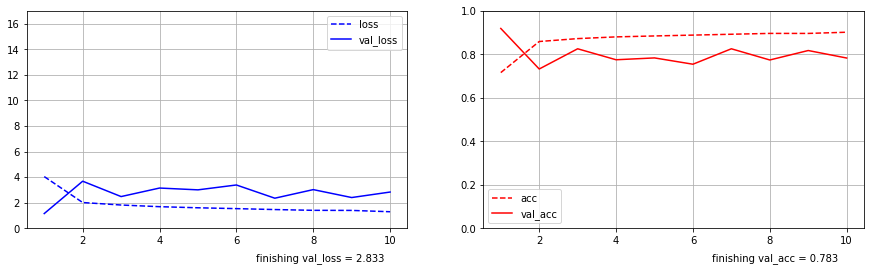


MODEL 2
start filters:  4
conv layers:    1
dense layers:   1
dense nodes:    50


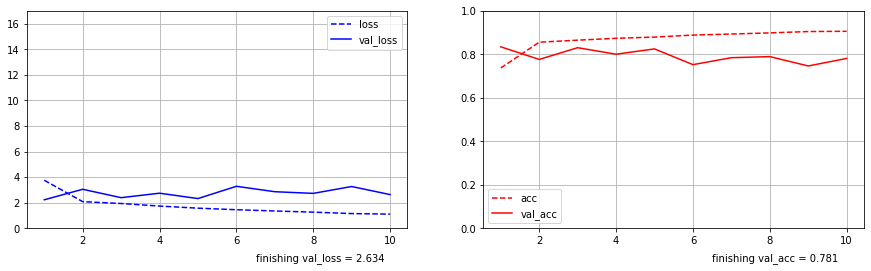


MODEL 3
start filters:  4
conv layers:    1
dense layers:   2
dense nodes:    20


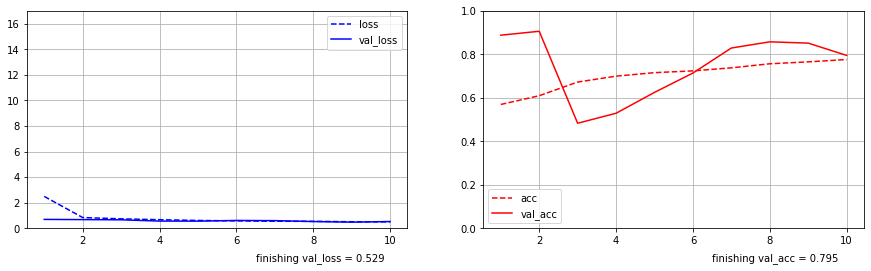


MODEL 4
start filters:  4
conv layers:    1
dense layers:   2
dense nodes:    50


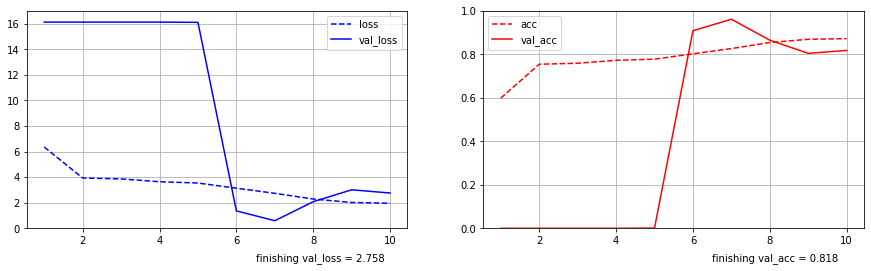


MODEL 5
start filters:  4
conv layers:    2
dense layers:   1
dense nodes:    20


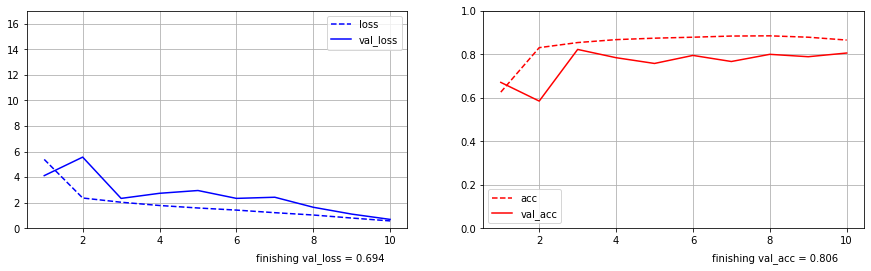


MODEL 6
start filters:  4
conv layers:    2
dense layers:   1
dense nodes:    50


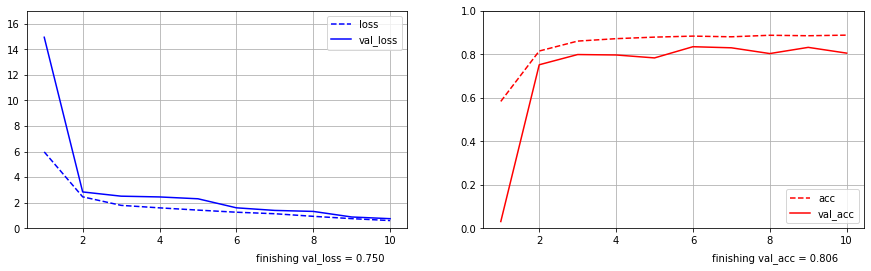


MODEL 7
start filters:  4
conv layers:    2
dense layers:   2
dense nodes:    20


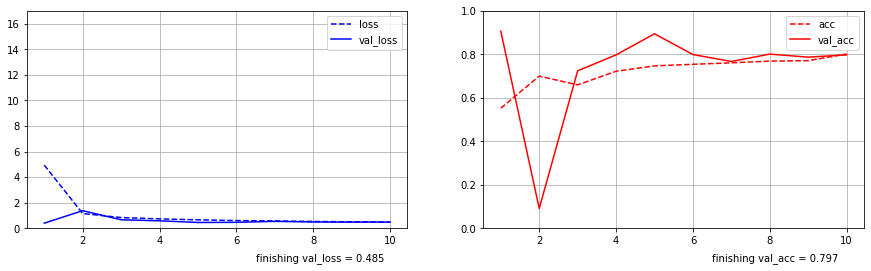


MODEL 8
start filters:  4
conv layers:    2
dense layers:   2
dense nodes:    50


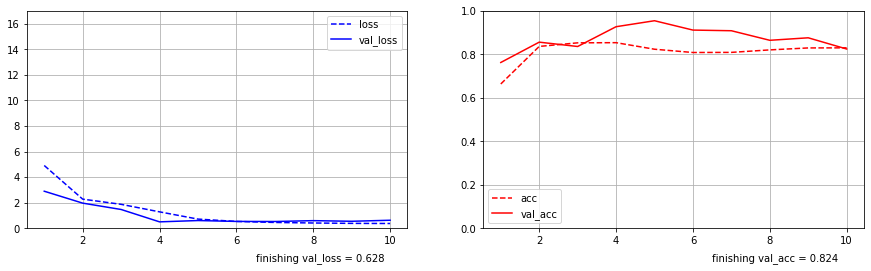


MODEL 9
start filters:  8
conv layers:    1
dense layers:   1
dense nodes:    20


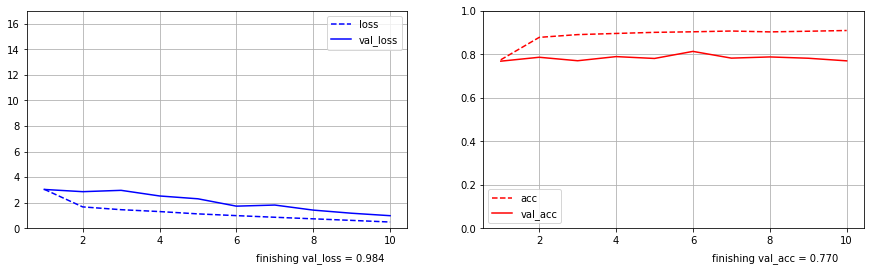


MODEL 10
start filters:  8
conv layers:    1
dense layers:   1
dense nodes:    50


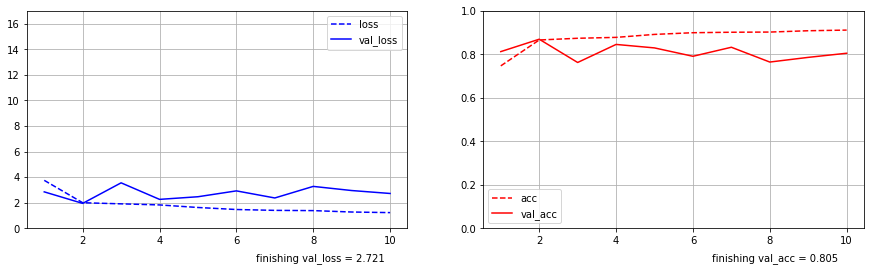


MODEL 11
start filters:  8
conv layers:    1
dense layers:   2
dense nodes:    20


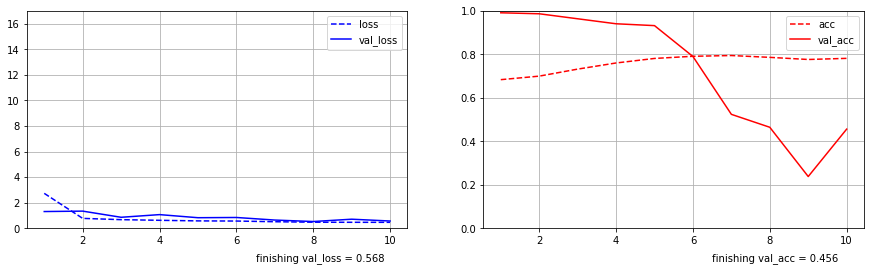


MODEL 12
start filters:  8
conv layers:    1
dense layers:   2
dense nodes:    50


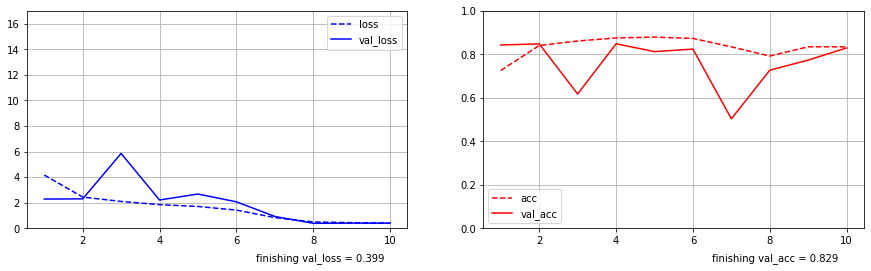


MODEL 13
start filters:  8
conv layers:    2
dense layers:   1
dense nodes:    20


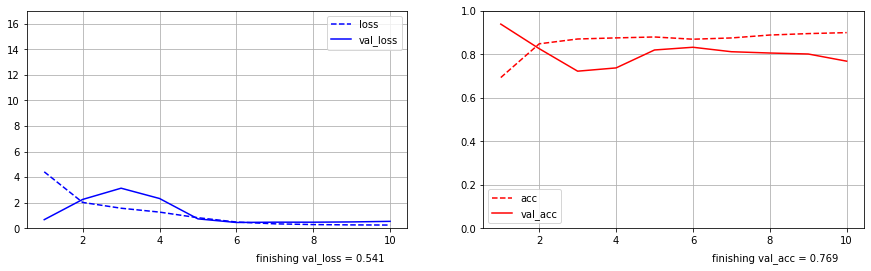


MODEL 14
start filters:  8
conv layers:    2
dense layers:   1
dense nodes:    50


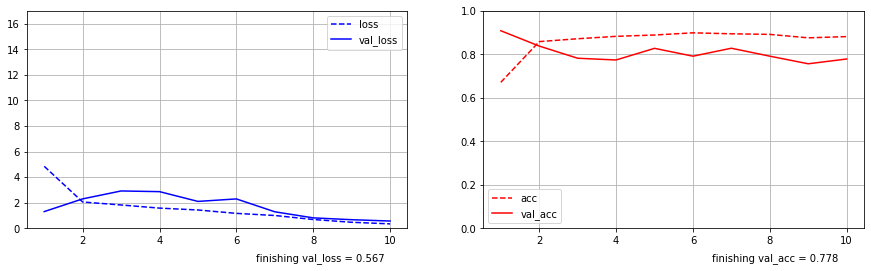


MODEL 15
start filters:  8
conv layers:    2
dense layers:   2
dense nodes:    20


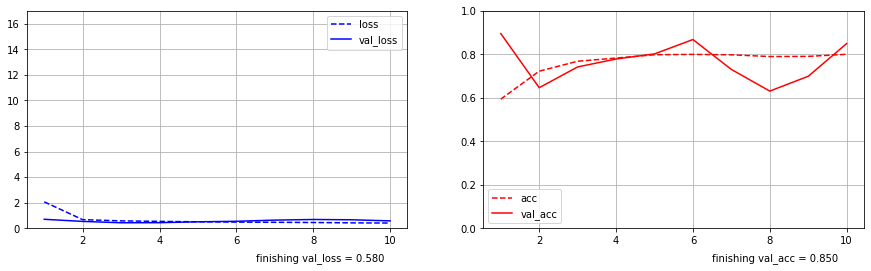


MODEL 16
start filters:  8
conv layers:    2
dense layers:   2
dense nodes:    50


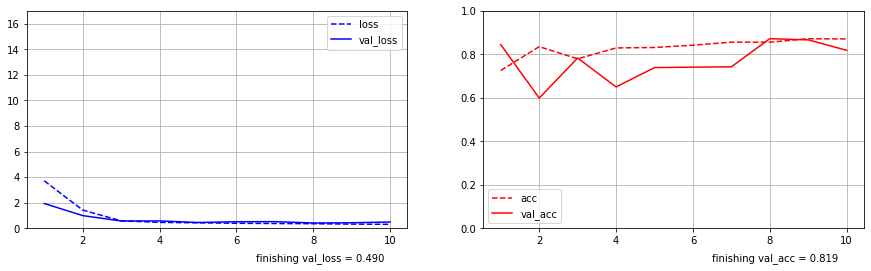

In [125]:
for ii in range(len(results_df_exp1)):
    print('\nMODEL {}'.format(ii+1))
    print('start filters:  {}'.format(results_df_exp1.loc[ii, 'n_start_filters']))
    print('conv layers:    {}'.format(results_df_exp1.loc[ii, 'n_conv_layers']))
    print('dense layers:   {}'.format(results_df_exp1.loc[ii, 'n_dense_layers']))
    print('dense nodes:    {}'.format(results_df_exp1.loc[ii, 'n_dense_nodes']))

    x = np.arange(1, 11)

    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(x, results_df_exp1.loc[ii, 'loss'], ls='--', c='b', label='loss')
    plt.plot(x, results_df_exp1.loc[ii, 'val_loss'], c='b', label='val_loss')
    plt.legend()
    plt.ylim(0, 17)
    plt.grid()
    plt.text(6.5, -2.5, 'finishing val_loss = {:.3f}'.format(results_df_exp1.loc[ii, 'val_loss'][9]))

    plt.subplot(122)
    plt.plot(x, results_df_exp1.loc[ii, 'acc'], ls='--', c='r', label='acc')
    plt.plot(x, results_df_exp1.loc[ii, 'val_acc'], c='r', label='val_acc')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid()
    plt.text(6.5, -0.15, 'finishing val_acc = {:.3f}'.format(results_df_exp1.loc[ii, 'val_acc'][9]))
    
    plt.show()

**Observations**

* Some good overall accurcies here.  I have no benchmark (e.g. human performance) available but many of the models are achieving > 80 % accuracy on the validation sets.

* Difficult to tell if overfitting is taking place but none of the models show a very high training accuracy with a lower validationtion acuracy (e.g. 99.9 vs. 80.0).

* Models 9 & 10 show a consistent disparity between training and validation scores.  Thes models both have 8 starting filters, only 1 convolutional layer and 1 dense layer (which is the 4 node output layer).

* Model 11 has some unusual accuracy scores - there is a large idisparity which might indicate overfit, however the losses are similar.

There is no obvious choice here for the best model so I will have a look at the average socres for each hyperparameter setting:

In [25]:
results_df_exp1['max_val_acc'] = results_df_exp1.val_acc.apply(lambda x: np.max(x))
results_df_exp1['finishing_val_loss'] = results_df_exp1.val_loss.apply(lambda x: x[9])

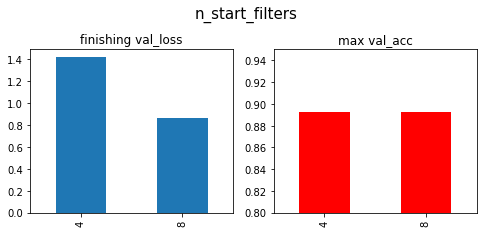

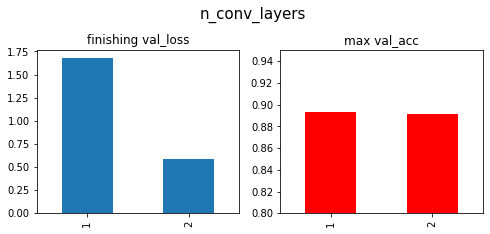

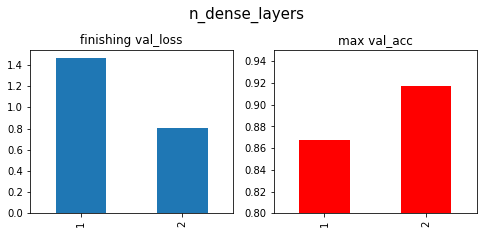

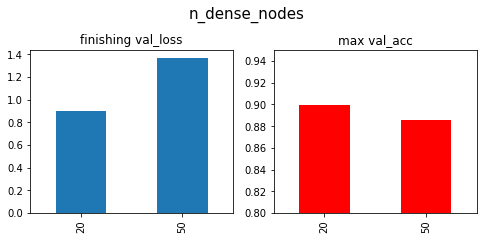

In [62]:
for hyperparameter in ['n_start_filters', 'n_conv_layers', 'n_dense_layers', 'n_dense_nodes']:
    grouped = results_df_exp1.groupby(hyperparameter)
    
    plt.figure(figsize=(8, 3))
    plt.suptitle(hyperparameter, y=1.08, size=15)
    plt.subplot(121)
    ax = grouped.finishing_val_loss.mean().plot(kind='bar')
    ax.set_xlabel('')
    plt.title('finishing val_loss')
    
    plt.subplot(122)
    ax = grouped.max_val_acc.mean().plot(kind='bar', color='red')
    ax.set_xlabel('')
    plt.title('max val_acc')
    plt.ylim(0.8, 0.95)

**Observations**

Here there seems to be a clearer difference between the hyperpameter settings, mainly in the loss metric.  *Note: The bars do not show confidence intervals and interactions are not taken into account - these could be studied for further model optimisation.

The lowest validation losses are for the settings:
* 8 start filters
* 2 convolutional layers
* 2 dense layers
* 20 dense nodes

This was model 15 which showed similar values for training and validation losses, which is good.  For accuracy it showed fluctiuation of the valiodation score but no consistent seperation.

## Eperiment 2

To further investigate I will run model 15 over 200 epochs and also include an aditional model with 3 convolutional layers as decrease in loss from 1 to 2 was great I would like to find out if this continues:

In [92]:
# Declare dictionanary to store the results.
results = {
    'model': [],
    'n_conv_layers': [],
    'loss': [],
    'val_loss': [],
    'acc': [],
    'val_acc': [],
}

# Iterate through hyperparameters / structure parameters.
model_number = 1
for n_conv_layer in [2, 3]:
    print('\n\nExperiment 2 model number {}'.format(model_number))
    model_number += 1

    model = model_builder(
        n_start_filters=8,
        n_conv_layers=n_conv_layer,
        n_conv_reps=1,
        padding='same',
        activations='relu',
        n_dense_layers=2,
        n_dense_nodes=20,
        dropout=0.5,
    )

    history = model.fit(X_train, y_train, epochs=200, batch_size=1000, validation_split=0.1)

    results['model'].append(model)
    results['n_conv_layers'].append(n_conv_layer)
    results['loss'].append(history.history['loss'])
    results['val_loss'].append(history.history['val_loss'])
    results['acc'].append(history.history['acc'])
    results['val_acc'].append(history.history['val_acc'])

# Store results in dataframe and save.
results_df_exp2 = pd.DataFrame(results)
results_df_exp2.to_pickle('results_df_exp2.pickle')



Experiment 2 model number 1
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 6s 354us/step - loss: 2.3131 - acc: 0.6169 - val_loss: 0.7056 - val_acc: 0.6835
Epoch 2/200
18000/18000 [==============================] - 4s 201us/step - loss: 0.6721 - acc: 0.7075 - val_loss: 0.5679 - val_acc: 0.8570
Epoch 3/200
18000/18000 [==============================] - 3s 190us/step - loss: 0.5921 - acc: 0.7584 - val_loss: 0.4507 - val_acc: 0.8200
Epoch 4/200
18000/18000 [==============================] - 3s 189us/step - loss: 0.5462 - acc: 0.7724 - val_loss: 0.5081 - val_acc: 0.7280
Epoch 5/200
18000/18000 [==============================] - 3s 188us/step - loss: 0.5211 - acc: 0.7772 - val_loss: 0.4963 - val_acc: 0.6495
Epoch 6/200
18000/18000 [==============================] - 3s 189us/step - loss: 0.4951 - acc: 0.7849 - val_loss: 0.5144 - val_acc: 0.6495
Epoch 7/200
18000/18000 [==============================] - 3s 190us/step - loss: 0.4604

18000/18000 [==============================] - 4s 204us/step - loss: 0.2369 - acc: 0.8906 - val_loss: 0.3649 - val_acc: 0.7960
Epoch 60/200
18000/18000 [==============================] - 4s 206us/step - loss: 0.2320 - acc: 0.8957 - val_loss: 0.3651 - val_acc: 0.8210
Epoch 61/200
18000/18000 [==============================] - 4s 206us/step - loss: 0.2290 - acc: 0.8971 - val_loss: 0.4294 - val_acc: 0.7445
Epoch 62/200
18000/18000 [==============================] - 4s 207us/step - loss: 0.2301 - acc: 0.8930 - val_loss: 0.4166 - val_acc: 0.7550
Epoch 63/200
18000/18000 [==============================] - 4s 208us/step - loss: 0.2289 - acc: 0.8932 - val_loss: 0.3777 - val_acc: 0.8065
Epoch 64/200
18000/18000 [==============================] - 4s 204us/step - loss: 0.2308 - acc: 0.8919 - val_loss: 0.3690 - val_acc: 0.8070
Epoch 65/200
18000/18000 [==============================] - 4s 212us/step - loss: 0.2278 - acc: 0.8936 - val_loss: 0.3421 - val_acc: 0.8175
Epoch 66/200
18000/18000 [=======

18000/18000 [==============================] - 4s 203us/step - loss: 0.1845 - acc: 0.9089 - val_loss: 0.3815 - val_acc: 0.8115
Epoch 118/200
18000/18000 [==============================] - 4s 207us/step - loss: 0.1902 - acc: 0.9083 - val_loss: 0.3218 - val_acc: 0.8520
Epoch 119/200
18000/18000 [==============================] - 4s 208us/step - loss: 0.1865 - acc: 0.9076 - val_loss: 0.3794 - val_acc: 0.8140
Epoch 120/200
18000/18000 [==============================] - 4s 205us/step - loss: 0.1877 - acc: 0.9114 - val_loss: 0.3622 - val_acc: 0.8335
Epoch 121/200
18000/18000 [==============================] - 4s 204us/step - loss: 0.1849 - acc: 0.9076 - val_loss: 0.3829 - val_acc: 0.8200
Epoch 122/200
18000/18000 [==============================] - 4s 207us/step - loss: 0.1827 - acc: 0.9107 - val_loss: 0.4592 - val_acc: 0.7785
Epoch 123/200
18000/18000 [==============================] - 4s 207us/step - loss: 0.1863 - acc: 0.9078 - val_loss: 0.3747 - val_acc: 0.8265
Epoch 124/200
18000/18000 [

18000/18000 [==============================] - 4s 215us/step - loss: 0.1690 - acc: 0.9187 - val_loss: 0.3866 - val_acc: 0.8300
Epoch 176/200
18000/18000 [==============================] - 4s 216us/step - loss: 0.1683 - acc: 0.9179 - val_loss: 0.3342 - val_acc: 0.8510
Epoch 177/200
18000/18000 [==============================] - 4s 218us/step - loss: 0.1710 - acc: 0.9169 - val_loss: 0.3286 - val_acc: 0.8575
Epoch 178/200
18000/18000 [==============================] - 4s 213us/step - loss: 0.1707 - acc: 0.9186 - val_loss: 0.3797 - val_acc: 0.8375
Epoch 179/200
18000/18000 [==============================] - 4s 214us/step - loss: 0.1666 - acc: 0.9208 - val_loss: 0.5526 - val_acc: 0.7640
Epoch 180/200
18000/18000 [==============================] - 4s 212us/step - loss: 0.1667 - acc: 0.9191 - val_loss: 0.3590 - val_acc: 0.8470
Epoch 181/200
18000/18000 [==============================] - 4s 212us/step - loss: 0.1638 - acc: 0.9197 - val_loss: 0.3371 - val_acc: 0.8560
Epoch 182/200
18000/18000 [

Epoch 33/200
18000/18000 [==============================] - 4s 236us/step - loss: 0.2402 - acc: 0.8931 - val_loss: 0.4134 - val_acc: 0.8040
Epoch 34/200
18000/18000 [==============================] - 4s 238us/step - loss: 0.2329 - acc: 0.8924 - val_loss: 0.4258 - val_acc: 0.8175
Epoch 35/200
18000/18000 [==============================] - 4s 241us/step - loss: 0.2328 - acc: 0.8978 - val_loss: 0.4233 - val_acc: 0.7970
Epoch 36/200
18000/18000 [==============================] - 4s 242us/step - loss: 0.2348 - acc: 0.8922 - val_loss: 0.3650 - val_acc: 0.8675
Epoch 37/200
18000/18000 [==============================] - 4s 240us/step - loss: 0.2308 - acc: 0.8966 - val_loss: 0.4103 - val_acc: 0.8215
Epoch 38/200
18000/18000 [==============================] - 4s 237us/step - loss: 0.2310 - acc: 0.8946 - val_loss: 0.4019 - val_acc: 0.8375
Epoch 39/200
18000/18000 [==============================] - 5s 256us/step - loss: 0.2245 - acc: 0.8992 - val_loss: 0.3441 - val_acc: 0.8590
Epoch 40/200
18000/1

18000/18000 [==============================] - 4s 227us/step - loss: 0.1717 - acc: 0.9227 - val_loss: 0.3526 - val_acc: 0.8755
Epoch 92/200
18000/18000 [==============================] - 4s 229us/step - loss: 0.1737 - acc: 0.9251 - val_loss: 0.4010 - val_acc: 0.8470
Epoch 93/200
18000/18000 [==============================] - 5s 252us/step - loss: 0.1745 - acc: 0.9236 - val_loss: 0.4347 - val_acc: 0.8315
Epoch 94/200
18000/18000 [==============================] - 5s 269us/step - loss: 0.1698 - acc: 0.9257 - val_loss: 0.4030 - val_acc: 0.8480
Epoch 95/200
18000/18000 [==============================] - 5s 250us/step - loss: 0.1704 - acc: 0.9256 - val_loss: 0.3703 - val_acc: 0.8595
Epoch 96/200
18000/18000 [==============================] - 5s 284us/step - loss: 0.1715 - acc: 0.9232 - val_loss: 0.4243 - val_acc: 0.8140
Epoch 97/200
18000/18000 [==============================] - 4s 249us/step - loss: 0.1687 - acc: 0.9263 - val_loss: 0.3700 - val_acc: 0.8620
Epoch 98/200
18000/18000 [=======

18000/18000 [==============================] - 5s 270us/step - loss: 0.1466 - acc: 0.9368 - val_loss: 0.4445 - val_acc: 0.8495
Epoch 150/200
18000/18000 [==============================] - 5s 292us/step - loss: 0.1481 - acc: 0.9349 - val_loss: 0.4387 - val_acc: 0.8495
Epoch 151/200
18000/18000 [==============================] - 5s 269us/step - loss: 0.1448 - acc: 0.9378 - val_loss: 0.4043 - val_acc: 0.8635
Epoch 152/200
18000/18000 [==============================] - 5s 271us/step - loss: 0.1410 - acc: 0.9387 - val_loss: 0.4507 - val_acc: 0.8560
Epoch 153/200
18000/18000 [==============================] - 5s 263us/step - loss: 0.1451 - acc: 0.9373 - val_loss: 0.4318 - val_acc: 0.8615
Epoch 154/200
18000/18000 [==============================] - 5s 274us/step - loss: 0.1420 - acc: 0.9387 - val_loss: 0.4741 - val_acc: 0.8395
Epoch 155/200
18000/18000 [==============================] - 4s 242us/step - loss: 0.1446 - acc: 0.9398 - val_loss: 0.4242 - val_acc: 0.8640
Epoch 156/200
18000/18000 [

In [ ]:
results_df_exp2 = pd.read_pickle('results_df_exp2.pickle')


MODEL 1
conv layers:    2


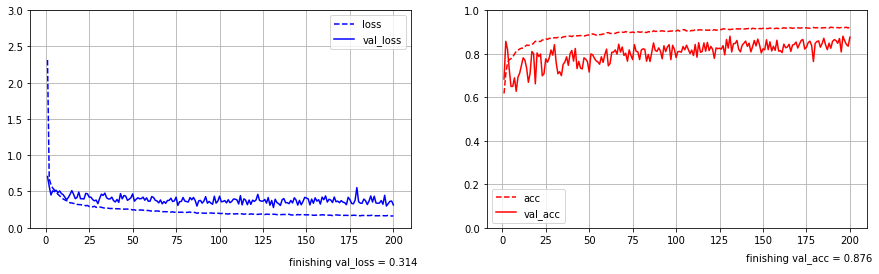


MODEL 2
conv layers:    3


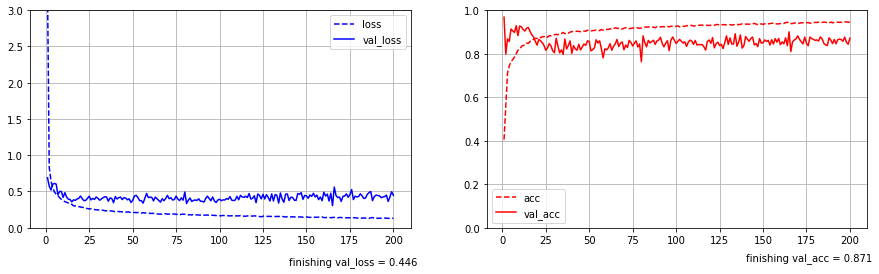

In [126]:
n_epochs = 200

for ii in range(len(results_df_exp2)):
    print('\nMODEL {}'.format(ii+1))
    print('conv layers:    {}'.format(results_df_exp2.loc[ii, 'n_conv_layers']))

    x = np.arange(1, n_epochs+1)

    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(x, results_df_exp2.loc[ii, 'loss'], ls='--', c='b', label='loss')
    plt.plot(x, results_df_exp2.loc[ii, 'val_loss'], c='b', label='val_loss')
    plt.legend()
    plt.ylim(0, 3)
    plt.grid()
    plt.text(140, -0.5, 'finishing val_loss = {:.3f}'.format(results_df_exp2.loc[ii, 'val_loss'][199]))
#     plt.xlim(0, 100)
    
    plt.subplot(122)
    plt.plot(x, results_df_exp2.loc[ii, 'acc'], ls='--', c='r', label='acc')
    plt.plot(x, results_df_exp2.loc[ii, 'val_acc'], c='r', label='val_acc')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid()
    plt.text(140, -0.15, 'finishing val_acc = {:.3f}'.format(results_df_exp2.loc[ii, 'val_acc'][199]))
#     plt.xlim(0, 100)
    
    plt.show()

**Observations**

* Both models show a lower validation performance than training after around 15 epochs, possibly indicating some overfitting.
* Model 2 shows greater divergance between loss and validation loss over the course of the full 50 epochs.
* Validation loss flattens at approximately 0.4, possibly indicating the limit of performance for this general model architecture.

Both models have similar performance but should clearly be run over few epochs with trainin - validation divergance at about 30 and 15 epochs for model 1 and model 2 respectively.  As model 2 shows higher accuracy at it's divergence I will go with this for the final model and re-run this over 15 epochs below, training on all training data:

In [111]:
final_model = model_builder(n_start_filters=8,
                            n_conv_layers=3,
                            n_conv_reps=1,
                            padding='same',
                            activations='relu',
                            n_dense_layers=2,
                            n_dense_nodes=20,
                            dropout=0.5)

final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 1568)              0         
__________

In [112]:
history = final_model.fit(X_train, y_train, epochs=15, batch_size=1000)

Epoch 1/15
20000/20000 [==============================] - 7s 328us/step - loss: 3.7142 - acc: 0.5751
Epoch 2/15
20000/20000 [==============================] - 4s 190us/step - loss: 0.8915 - acc: 0.6378
Epoch 3/15
20000/20000 [==============================] - 4s 196us/step - loss: 0.7714 - acc: 0.7052
Epoch 4/15
20000/20000 [==============================] - 4s 193us/step - loss: 0.7021 - acc: 0.7396
Epoch 5/15
20000/20000 [==============================] - 4s 195us/step - loss: 0.6600 - acc: 0.7450
Epoch 6/15
20000/20000 [==============================] - 4s 194us/step - loss: 0.6069 - acc: 0.7475
Epoch 7/15
20000/20000 [==============================] - 4s 196us/step - loss: 0.5673 - acc: 0.7319
Epoch 8/15
20000/20000 [==============================] - 4s 193us/step - loss: 0.5428 - acc: 0.7415
Epoch 9/15
20000/20000 [==============================] - 4s 197us/step - loss: 0.5260 - acc: 0.7367
Epoch 10/15
20000/20000 [==============================] - 4s 199us/step - loss: 0.5185 - a

FINAL MODEL
Accuracy:  0.874
Loss:  0.244


Text(0.5, 1.0, 'Accuracy')

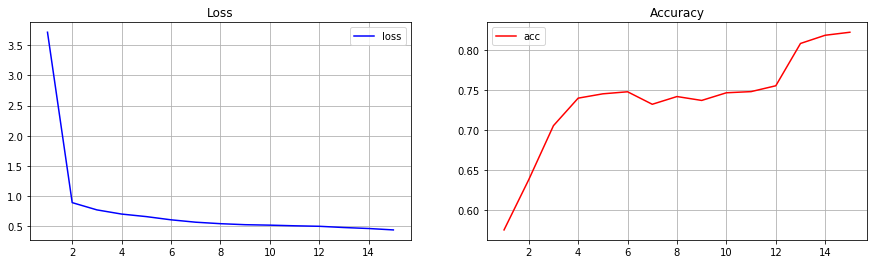

In [123]:
loss, accuracy = final_model.evaluate(X_train, y_train, verbose=0)

print('FINAL MODEL')
print('Accuracy:  {:.3f}'.format(accuracy))
print('Loss:  {:.3f}'.format(loss))

x = np.arange(1, 16)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(x, history.history['loss'], c='b', label='loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.subplot(122)
plt.plot(x, history.history['acc'], c='r', label='acc')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [127]:
final_model.save('model.h5')